# core

> Fill in a module description here

In [ ]:
# | default_exp core

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
loan_data = pd.read_csv("../data/loan_data_2007_2014.csv", low_memory=False)

In [ ]:
loan_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.00,0.00,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,Financial Advisor,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,773xx,TX,19.85,0.0,Apr-03,2.0,NaN,N

In [ ]:
# drop columns with more than 80% null values
loan_data = loan_data.dropna(thresh=loan_data.shape[0] * 0.2, how="all", axis=1)

In [ ]:
loan_data.shape

(466285, 56)

In [ ]:
# drop all redundant and forward-looking columns
loan_data = loan_data.drop(
    columns=[
        "id",
        "member_id",
        "sub_grade",
        "emp_title",
        "url",
        "desc",
        "title",
        "zip_code",
        "next_pymnt_d",
        "recoveries",
        "collection_recovery_fee",
        "total_rec_prncp",
        "total_rec_late_fee",
    ]
)

In [ ]:
loan_data.shape

(466285, 43)

In [ ]:
# explore the unique values in loan_status column
loan_data["loan_status"].value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [ ]:
# create a new column based on the loan_status column that will be our target variable
default_columns = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Does not meet the credit policy. Status:Charged Off",
]
loan_data["good_bad"] = np.where(loan_data.loc[:, "loan_status"].isin(default_columns), 0, 1)

In [ ]:
loan_data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.00,0.00,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,other,OR,17.94,0.0,Jan-96,0.0,38.0,15.0,0.0,27783,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60 months,14.47,432.64,C,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,Current,n,debt_consolidation,TX,19.85,0.0,Apr-03,2.0,NaN,18.0,0.0,23208,77.6,36.0,w,12574.00,12574.00,10383.360000,10383.36,4557.36,Jan-16,432.64,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,294998.0,29900.0,1
466281,22000,22000,22000.0,60 months,19.97,582.50,D,10+ years,MORTGAGE,78000.0,Verified,Jan-14,Charged Off,n,debt_consolidation,TN,18.45,0.0,Jun-97,5.0,NaN,18.0,1.0,18238,46.3,30.0,f,0.00,0.00,4677.920000,4677.92,2840.88,Dec-14,17.50,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,221830.0,39400.0,0
466282,20700,20700,20700.0,60 months,16.99,514.34,D,7 years,MORTGAGE,46000.0,Verified,Jan-14,Current,n,debt_consolidation,OH,25.65,0.0,Dec-01,2.0,65.0,18.0,0.0,6688,51.1,43.0,f,14428.31,14428.31,12343.980000,12343.98,6072.29,Jan-16,514.34,Dec-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,73598.0,13100.0,1
466283,2000,2000,2000.0,36 months,7.90,62.59,A,3 years,OWN,83000.0,Verified,Jan-14,Fully Paid,n,credit_card,CA,5.39,3.0,Feb-03,1.0,13.0,21.0,0.0,11404,21.5,27.0,w,0.00,0.00,2126.579838,2126.58,126.58,Dec-14,1500.68,Apr-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,591610.0,53100.0,1


In [ ]:
# Drop the original 'loan_status' column
loan_data = loan_data.drop(columns=["loan_status"])

In [ ]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop("good_bad", axis=1)
y = loan_data["good_bad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Hard copy the X datasets to avoid Pandas' `SetttingWithCopyWarning` when we play around with this data later on. This is currently an open issue between Pandas and Scikit-Learn teams

In [ ]:
X_train, X_test = X_train.copy(), X_test.copy()

In [ ]:
print(X_train.shape, y_train.shape)

(373028, 42) (373028,)


Function to clean up the emp_length column, assign 0 to NANs, and convert to numeric

In [ ]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace("\+ years", "")
    df[column] = df[column].str.replace("< 1 year", str(0))
    df[column] = df[column].str.replace(" years", "")
    df[column] = df[column].str.replace(" year", "")
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value=0, inplace=True)
    return df

Function to convert date columns to datetime format and create a new column as a difference between today and the respective date

In [ ]:
def date_columns(df, column):
    today_date = pd.to_datetime("2020-08-01")  # store current month
    df[column] = pd.to_datetime(df[column], format="%b-%y")  # convert to datetime format
    # calculate the difference in months and add to a new column
    df[f"mths_since_{column}"] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, "M")))
    # make any resulting -ve values to be equal to the max date
    df[f"mths_since_{column}"] = df[f"mths_since_{column}"].apply(
        lambda x: df[f"mths_since_{column}"].max() if x < 0 else x
    )
    df = df.drop(columns=[column])  # drop the original date column
    return df

In [ ]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(" months", ""))
    return df

In [ ]:
# apply these functions to X_train
X_train = date_columns(X_train, "earliest_cr_line")
X_train = date_columns(X_train, "issue_d")
X_train = date_columns(X_train, "last_pymnt_d")
X_train = date_columns(X_train, "last_credit_pull_d")
X_train = emp_length_converter(X_train, "emp_length")
X_train = loan_term_converter(X_train, "term")

/var/folders/qz/3pl78vgn6t7cltx35ttht03r0000gn/T/ipykernel_18263/1071858157.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace("\+ years", "")


In [ ]:
X_train

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
456615,15000,15000,15000.0,36,8.90,476.30,A,7.0,MORTGAGE,80000.0,Source Verified,n,credit_card,WI,17.01,1.0,0.0,20.0,19.0,0.0,20699,59.0,32.0,w,0.00,0.00,16561.02000,16561.02,1561.02,8940.22,0.0,NaN,1,INDIVIDUAL,0.0,0.0,143586.0,35100.0,296.0,79.0,62.0,55.0
451541,8000,8000,8000.0,60,18.25,204.24,D,10.0,OWN,44000.0,Verified,n,other,TN,23.46,0.0,1.0,NaN,12.0,0.0,13245,32.1,25.0,f,5746.54,5746.54,4697.52000,4697.52,2444.06,204.24,0.0,NaN,1,INDIVIDUAL,0.0,0.0,180443.0,41300.0,301.0,79.0,55.0,55.0
394474,12150,12150,12100.0,60,18.92,314.65,D,3.0,OWN,27000.0,Source Verified,n,credit_card,TN,31.07,1.0,0.0,10.0,9.0,0.0,7172,73.2,22.0,f,9282.24,9244.04,6293.00000,6267.10,3425.24,314.65,0.0,NaN,1,INDIVIDUAL,0.0,0.0,34197.0,9800.0,359.0,75.0,55.0,55.0
110294,10000,10000,10000.0,36,6.03,304.36,A,3.0,MORTGAGE,33000.0,Not Verified,n,debt_consolidation,TN,9.16,0.0,0.0,NaN,5.0,0.0,2138,21.2,17.0,w,0.00,0.00,10858.01000,10858.01,858.01,3553.37,0.0,NaN,1,INDIVIDUAL,0.0,0.0,77959.0,10100.0,224.0,84.0,59.0,59.0
139343,15825,15825,15825.0,36,12.12,526.53,B,10.0,MORTGAGE,59000.0,Verified,n,debt_consolidation,WA,17.94,0.0,0.0,NaN,7.0,0.0,30326,93.6,31.0,f,0.00,0.00,4736.52000,4736.52,1301.35,526.53,0.0,NaN,1,INDIVIDUAL,0.0,0.0,187370.0,32400.0,494.0,87.0,78.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,22800,22800,22800.0,60,16.29,557.98,C,10.0,MORTGAGE,85000.0,Verified,n,debt_consolidation,CA,15.12,0.0,0.0,38.0,15.0,0.0,18556,67.5,22.0,f,12158.37,12158.37,18968.20000,18968.20,8326.57,557.98,0.0,NaN,1,INDIVIDUAL,0.0,0.0,29071.0,27500.0,253.0,90.0,55.0,55.0
399306,20275,20275,20175.0,36,12.49,678.18,B,7.0,MORTGAGE,48000.0,Verified,n,credit_card,KS,22.70,0.0,0.0,NaN,7.0,0.0,33997,75.0,20.0,w,9947.82,9898.75,13563.60000,13496.70,3236.42,678.18,0.0,NaN,1,INDIVIDUAL,0.0,0.0,186530.0,45300.0,230.0,75.0,55.0,55.0
57787,25000,25000,24975.0,60,14.30,585.61,C,0.0,MORTGAGE,65530.0,Verified,n,debt_consolidation,CO,22.91,0.0,0.0,NaN,8.0,0.0,11848,68.1,24.0,f,0.00,0.00,30285.29598,30255.01,5285.30,19162.85,0.0,NaN,1,INDIVIDUAL,0.0,0.0,290599.0,17400.0,314.0,81.0,60.0,56.0
81641,10000,10000,10000.0,36,15.10,347.15,C,4.0,MORTGAGE,50000.0,Not Verified,n,debt_consolidation,FL,14.24,1.0,1.0,10.0,7.0,0.0,9693,65.1,9.0,w,2936.24,2936.24,9373.05000,9373.05,2309.29,347.15,0.0,40.0,1,INDIVIDUAL,0.0,0.0,27715.0,14900.0,156.0,82.0,55.0,55.0


In [ ]:
print(X_train.shape, y_train.shape)

(373028, 42) (373028,)


In [ ]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include="object").copy()
X_train_num = X_train.select_dtypes(include="number").copy()

In [ ]:
chi2_check = {}  # define an empty dictionary to store chi-squared test results
# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault("Feature", []).append(column)
    chi2_check.setdefault("p-value", []).append(round(p, 10))
chi2_result = pd.DataFrame(data=chi2_check)  # convert the dictionary to a DF
chi2_result.sort_values(by=["p-value"], ascending=True, ignore_index=True, inplace=True)

In [ ]:
chi2_result

,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,pymnt_plan,0.000923
7,application_type,1.000000


/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<AxesSubplot:>

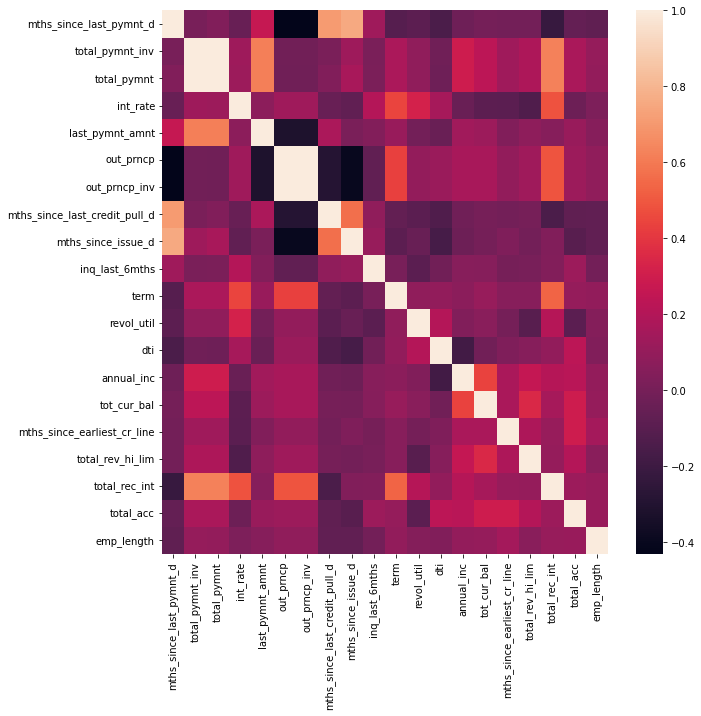

In [ ]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace=True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(
    data={
        "Numerical_Feature": X_train_num.columns.values,
        "F-Score": F_statistic,
        "p values": p_values.round(decimals=10),
    }
)
ANOVA_F_table = ANOVA_F_table.sort_values(by=["F-Score"], ascending=False, ignore_index=True)

# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20, 0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat)

In [ ]:
# save the names of columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(["out_prncp_inv", "total_pymnt_inv"])

# function to drop these columns
def col_to_drop(df, columns_list):
    df = df.drop(columns=columns_list)
    return df


# apply to X_train
X_train = col_to_drop(X_train, drop_columns_list)

In [ ]:
X_train

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
456615,36,8.90,A,7.0,MORTGAGE,80000.0,Source Verified,credit_card,17.01,0.0,59.0,32.0,0.00,16561.02000,1561.02,8940.22,143586.0,35100.0,296.0,79.0,62.0,55.0
451541,60,18.25,D,10.0,OWN,44000.0,Verified,other,23.46,1.0,32.1,25.0,5746.54,4697.52000,2444.06,204.24,180443.0,41300.0,301.0,79.0,55.0,55.0
394474,60,18.92,D,3.0,OWN,27000.0,Source Verified,credit_card,31.07,0.0,73.2,22.0,9282.24,6293.00000,3425.24,314.65,34197.0,9800.0,359.0,75.0,55.0,55.0
110294,36,6.03,A,3.0,MORTGAGE,33000.0,Not Verified,debt_consolidation,9.16,0.0,21.2,17.0,0.00,10858.01000,858.01,3553.37,77959.0,10100.0,224.0,84.0,59.0,59.0
139343,36,12.12,B,10.0,MORTGAGE,59000.0,Verified,debt_consolidation,17.94,0.0,93.6,31.0,0.00,4736.52000,1301.35,526.53,187370.0,32400.0,494.0,87.0,78.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,60,16.29,C,10.0,MORTGAGE,85000.0,Verified,debt_consolidation,15.12,0.0,67.5,22.0,12158.37,18968.20000,8326.57,557.98,29071.0,27500.0,253.0,90.0,55.0,55.0
399306,36,12.49,B,7.0,MORTGAGE,48000.0,Verified,credit_card,22.70,0.0,75.0,20.0,9947.82,13563.60000,3236.42,678.18,186530.0,45300.0,230.0,75.0,55.0,55.0
57787,60,14.30,C,0.0,MORTGAGE,65530.0,Verified,debt_consolidation,22.91,0.0,68.1,24.0,0.00,30285.29598,5285.30,19162.85,290599.0,17400.0,314.0,81.0,60.0,56.0
81641,36,15.10,C,4.0,MORTGAGE,50000.0,Not Verified,debt_consolidation,14.24,1.0,65.1,9.0,2936.24,9373.05000,2309.29,347.15,27715.0,14900.0,156.0,82.0,55.0,55.0


In [ ]:
print(X_train.shape, y_train.shape)

(373028, 22) (373028,)


In [ ]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix=col, prefix_sep=":"))
    df_dummies = pd.concat(df_dummies, axis=1)
    df = pd.concat([df, df_dummies], axis=1)
    return df

In [ ]:
# apply to our final four categorical variables
X_train = dummy_creation(X_train, ["grade", "home_ownership", "verification_status", "purpose"])

(373028, 22)
1
2
3
4
(373028, 29)
(373028, 51)


In [ ]:
print(X_train.shape, y_train.shape)

(373028, 51) (373028,)


In [ ]:
# update the test data with all functions defined so far
X_test = emp_length_converter(X_test, "emp_length")
X_test = date_columns(X_test, "earliest_cr_line")
X_test = date_columns(X_test, "issue_d")
X_test = date_columns(X_test, "last_pymnt_d")
X_test = date_columns(X_test, "last_credit_pull_d")
X_test = loan_term_converter(X_test, "term")
X_test = col_to_drop(X_test, drop_columns_list)

/var/folders/qz/3pl78vgn6t7cltx35ttht03r0000gn/T/ipykernel_18263/1071858157.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace("\+ years", "")


In [ ]:
X_test = dummy_creation(X_test, ["grade", "home_ownership", "verification_status", "purpose"])
# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

(93257, 22)
1
2
3
4
(93257, 30)
(93257, 52)


In [ ]:
X_train

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
456615,36,8.90,A,7.0,MORTGAGE,80000.0,Source Verified,credit_card,17.01,0.0,59.0,32.0,0.00,16561.02000,1561.02,8940.22,143586.0,35100.0,296.0,79.0,62.0,55.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
451541,60,18.25,D,10.0,OWN,44000.0,Verified,other,23.46,1.0,32.1,25.0,5746.54,4697.52000,2444.06,204.24,180443.0,41300.0,301.0,79.0,55.0,55.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
394474,60,18.92,D,3.0,OWN,27000.0,Source Verified,credit_card,31.07,0.0,73.2,22.0,9282.24,6293.00000,3425.24,314.65,34197.0,9800.0,359.0,75.0,55.0,55.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
110294,36,6.03,A,3.0,MORTGAGE,33000.0,Not Verified,debt_consolidation,9.16,0.0,21.2,17.0,0.00,10858.01000,858.01,3553.37,77959.0,10100.0,224.0,84.0,59.0,59.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
139343,36,12.12,B,10.0,MORTGAGE,59000.0,Verified,debt_consolidation,17.94,0.0,93.6,31.0,0.00,4736.52000,1301.35,526.53,187370.0,32400.0,494.0,87.0,78.0,55.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,60,16.29,C,10.0,MORTGAGE,85000.0,Verified,debt_consolidation,15.12,0.0,67.5,22.0,12158.37,18968.20000,8326.57,557.98,29071.0,27500.0,253.0,90.0,55.0,55.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
399306,36,12.49,B,7.0,MORTGAGE,48000.0,Verified,credit_card,22.70,0.0,75.0,20.0,9947.82,13563.60000,3236.42,678.18,186530.0,45300.0,230.0,75.0,55.0,55.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
57787,60,14.30,C,0.0,MORTGAGE,65530.0,Verified,debt_consolidation,22.91,0.0,68.1,24.0,0.00,30285.29598,5285.30,19162.85,290599.0,17400.0,314.0,81.0,60.0,56.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
81641,36,15.10,C,4.0,MORTGAGE,50000.0,Not Verified,debt_consolidation,14.24,1.0,65.1,9.0,2936.24,9373.05000,2309.29,347.15,27715.0,14900.0,156.0,82.0,55.0,55.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# function to calculate WoE and IV of categorical features
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis=1)
    df = pd.concat(
        [
            df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
            df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean(),
        ],
        axis=1,
    )
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], "n_obs", "prop_good"]
    df["prop_n_obs"] = df["n_obs"] / df["n_obs"].sum()
    df["n_good"] = df["prop_good"] * df["n_obs"]
    df["n_bad"] = (1 - df["prop_good"]) * df["n_obs"]
    df["prop_n_good"] = df["n_good"] / df["n_good"].sum()
    df["prop_n_bad"] = df["n_bad"] / df["n_bad"].sum()
    df["WoE"] = np.log(df["prop_n_good"] / df["prop_n_bad"])
    df = df.sort_values(["WoE"])
    df = df.reset_index(drop=True)
    df["diff_prop_good"] = df["prop_good"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    df["IV"] = (df["prop_n_good"] - df["prop_n_bad"]) * df["WoE"]
    df["IV"] = df["IV"].sum()
    return df

In [ ]:
"""
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
"""


def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis=1)
    df = pd.concat(
        [
            df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
            df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean(),
        ],
        axis=1,
    )
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], "n_obs", "prop_good"]
    df["prop_n_obs"] = df["n_obs"] / df["n_obs"].sum()
    df["n_good"] = df["prop_good"] * df["n_obs"]
    df["n_bad"] = (1 - df["prop_good"]) * df["n_obs"]
    df["prop_n_good"] = df["n_good"] / df["n_good"].sum()
    df["prop_n_bad"] = df["n_bad"] / df["n_bad"].sum()
    df["WoE"] = np.log(df["prop_n_good"] / df["prop_n_bad"])
    # df = df.sort_values(['WoE'])
    # df = df.reset_index(drop = True)
    df["diff_prop_good"] = df["prop_good"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    df["IV"] = (df["prop_n_good"] - df["prop_n_bad"]) * df["WoE"]
    df["IV"] = df["IV"].sum()
    return df

In [ ]:
# We set the default style of the graphs to the seaborn style.
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels=0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE["WoE"]
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker="o", linestyle="--", color="k")
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel("Weight of Evidence")
    plt.title(str("Weight of Evidence by " + df_WoE.columns[0]))
    plt.xticks(rotation=rotation_of_x_axis_labels)

In [ ]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = [
    "mths_since_last_credit_pull_d:>75",
    "mths_since_issue_d:>122",
    "mths_since_earliest_cr_line:>434",
    "total_rev_hi_lim:>79,780",
    "total_rec_int:>7,260",
    "total_pymnt:>25,000",
    "out_prncp:>15,437",
    "revol_util:>1.0",
    "inq_last_6mths:>4",
    "dti:>35.191",
    "annual_inc:>150K",
    "int_rate:>20.281",
    "term:60",
    "purpose:major_purch__car__home_impr",
    "verification_status:Not Verified",
    "home_ownership:MORTGAGE",
    "grade:G",
]

In [ ]:
# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X):  # no *args or *kargs
        self.X = X

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        X_new = X.loc[:, "grade:A":"grade:G"]
        X_new["home_ownership:OWN"] = X.loc[:, "home_ownership:OWN"]
        X_new["home_ownership:MORTGAGE"] = X.loc[:, "home_ownership:MORTGAGE"]
        X_new["home_ownership:OTHER_NONE_RENT"] = sum(
            [
                X["home_ownership:OTHER"],
                X["home_ownership:NONE"],
                X["home_ownership:RENT"],
            ]
        )
        X_new = pd.concat(
            [
                X_new,
                X.loc[:, "verification_status:Not Verified":"verification_status:Verified"],
            ],
            axis=1,
        )
        X_new["purpose:debt_consolidation"] = X.loc[:, "purpose:debt_consolidation"]
        X_new["purpose:credit_card"] = X.loc[:, "purpose:credit_card"]
        X_new["purpose:major_purch__car__home_impr"] = sum(
            [
                X["purpose:major_purchase"],
                X["purpose:car"],
                X["purpose:home_improvement"],
            ]
        )
        X_new["purpose:educ__ren_en__sm_b__mov"] = sum(
            [
                X["purpose:educational"],
                X["purpose:renewable_energy"],
                X["purpose:small_business"],
                X["purpose:moving"],
            ]
        )
        X_new["purpose:vacation__house__wedding__med__oth"] = sum(
            [
                X["purpose:vacation"],
                X["purpose:house"],
                X["purpose:wedding"],
                X["purpose:medical"],
                X["purpose:other"],
            ]
        )
        X_new["term:36"] = np.where((X["term"] == 36), 1, 0)
        X_new["term:60"] = np.where((X["term"] == 60), 1, 0)
        X_new["int_rate:<7.071"] = np.where((X["int_rate"] <= 7.071), 1, 0)
        X_new["int_rate:7.071-10.374"] = np.where((X["int_rate"] > 7.071) & (X["int_rate"] <= 10.374), 1, 0)
        X_new["int_rate:10.374-13.676"] = np.where((X["int_rate"] > 10.374) & (X["int_rate"] <= 13.676), 1, 0)
        X_new["int_rate:13.676-15.74"] = np.where((X["int_rate"] > 13.676) & (X["int_rate"] <= 15.74), 1, 0)
        X_new["int_rate:15.74-20.281"] = np.where((X["int_rate"] > 15.74) & (X["int_rate"] <= 20.281), 1, 0)
        X_new["int_rate:>20.281"] = np.where((X["int_rate"] > 20.281), 1, 0)
        X_new["annual_inc:missing"] = np.where(X["annual_inc"].isnull(), 1, 0)
        X_new["annual_inc:<28,555"] = np.where((X["annual_inc"] <= 28555), 1, 0)
        X_new["annual_inc:28,555-37,440"] = np.where((X["annual_inc"] > 28555) & (X["annual_inc"] <= 37440), 1, 0)
        X_new["annual_inc:37,440-61,137"] = np.where((X["annual_inc"] > 37440) & (X["annual_inc"] <= 61137), 1, 0)
        X_new["annual_inc:61,137-81,872"] = np.where((X["annual_inc"] > 61137) & (X["annual_inc"] <= 81872), 1, 0)
        X_new["annual_inc:81,872-102,606"] = np.where((X["annual_inc"] > 81872) & (X["annual_inc"] <= 102606), 1, 0)
        X_new["annual_inc:102,606-120,379"] = np.where((X["annual_inc"] > 102606) & (X["annual_inc"] <= 120379), 1, 0)
        X_new["annual_inc:120,379-150,000"] = np.where((X["annual_inc"] > 120379) & (X["annual_inc"] <= 150000), 1, 0)
        X_new["annual_inc:>150K"] = np.where((X["annual_inc"] > 150000), 1, 0)
        X_new["dti:<=1.6"] = np.where((X["dti"] <= 1.6), 1, 0)
        X_new["dti:1.6-5.599"] = np.where((X["dti"] > 1.6) & (X["dti"] <= 5.599), 1, 0)
        X_new["dti:5.599-10.397"] = np.where((X["dti"] > 5.599) & (X["dti"] <= 10.397), 1, 0)
        X_new["dti:10.397-15.196"] = np.where((X["dti"] > 10.397) & (X["dti"] <= 15.196), 1, 0)
        X_new["dti:15.196-19.195"] = np.where((X["dti"] > 15.196) & (X["dti"] <= 19.195), 1, 0)
        X_new["dti:19.195-24.794"] = np.where((X["dti"] > 19.195) & (X["dti"] <= 24.794), 1, 0)
        X_new["dti:24.794-35.191"] = np.where((X["dti"] > 24.794) & (X["dti"] <= 35.191), 1, 0)
        X_new["dti:>35.191"] = np.where((X["dti"] > 35.191), 1, 0)
        X_new["inq_last_6mths:missing"] = np.where(X["inq_last_6mths"].isnull(), 1, 0)
        X_new["inq_last_6mths:0"] = np.where((X["inq_last_6mths"] == 0), 1, 0)
        X_new["inq_last_6mths:1-2"] = np.where((X["inq_last_6mths"] >= 1) & (X["inq_last_6mths"] <= 2), 1, 0)
        X_new["inq_last_6mths:3-4"] = np.where((X["inq_last_6mths"] >= 3) & (X["inq_last_6mths"] <= 4), 1, 0)
        X_new["inq_last_6mths:>4"] = np.where((X["inq_last_6mths"] > 4), 1, 0)
        X_new["revol_util:missing"] = np.where(X["revol_util"].isnull(), 1, 0)
        X_new["revol_util:<0.1"] = np.where((X["revol_util"] <= 0.1), 1, 0)
        X_new["revol_util:0.1-0.2"] = np.where((X["revol_util"] > 0.1) & (X["revol_util"] <= 0.2), 1, 0)
        X_new["revol_util:0.2-0.3"] = np.where((X["revol_util"] > 0.2) & (X["revol_util"] <= 0.3), 1, 0)
        X_new["revol_util:0.3-0.4"] = np.where((X["revol_util"] > 0.3) & (X["revol_util"] <= 0.4), 1, 0)
        X_new["revol_util:0.4-0.5"] = np.where((X["revol_util"] > 0.4) & (X["revol_util"] <= 0.5), 1, 0)
        X_new["revol_util:0.5-0.6"] = np.where((X["revol_util"] > 0.5) & (X["revol_util"] <= 0.6), 1, 0)
        X_new["revol_util:0.6-0.7"] = np.where((X["revol_util"] > 0.6) & (X["revol_util"] <= 0.7), 1, 0)
        X_new["revol_util:0.7-0.8"] = np.where((X["revol_util"] > 0.7) & (X["revol_util"] <= 0.8), 1, 0)
        X_new["revol_util:0.8-0.9"] = np.where((X["revol_util"] > 0.8) & (X["revol_util"] <= 0.9), 1, 0)
        X_new["revol_util:0.9-1.0"] = np.where((X["revol_util"] > 0.9) & (X["revol_util"] <= 1.0), 1, 0)
        X_new["revol_util:>1.0"] = np.where((X["revol_util"] > 1.0), 1, 0)
        X_new["out_prncp:<1,286"] = np.where((X["out_prncp"] <= 1286), 1, 0)
        X_new["out_prncp:1,286-6,432"] = np.where((X["out_prncp"] > 1286) & (X["out_prncp"] <= 6432), 1, 0)
        X_new["out_prncp:6,432-9,005"] = np.where((X["out_prncp"] > 6432) & (X["out_prncp"] <= 9005), 1, 0)
        X_new["out_prncp:9,005-10,291"] = np.where((X["out_prncp"] > 9005) & (X["out_prncp"] <= 10291), 1, 0)
        X_new["out_prncp:10,291-15,437"] = np.where((X["out_prncp"] > 10291) & (X["out_prncp"] <= 15437), 1, 0)
        X_new["out_prncp:>15,437"] = np.where((X["out_prncp"] > 15437), 1, 0)
        X_new["total_pymnt:<10,000"] = np.where((X["total_pymnt"] <= 10000), 1, 0)
        X_new["total_pymnt:10,000-15,000"] = np.where((X["total_pymnt"] > 10000) & (X["total_pymnt"] <= 15000), 1, 0)
        X_new["total_pymnt:15,000-20,000"] = np.where((X["total_pymnt"] > 15000) & (X["total_pymnt"] <= 20000), 1, 0)
        X_new["total_pymnt:20,000-25,000"] = np.where((X["total_pymnt"] > 20000) & (X["total_pymnt"] <= 25000), 1, 0)
        X_new["total_pymnt:>25,000"] = np.where((X["total_pymnt"] > 25000), 1, 0)
        X_new["total_rec_int:<1,089"] = np.where((X["total_rec_int"] <= 1089), 1, 0)
        X_new["total_rec_int:1,089-2,541"] = np.where((X["total_rec_int"] > 1089) & (X["total_rec_int"] <= 2541), 1, 0)
        X_new["total_rec_int:2,541-4,719"] = np.where((X["total_rec_int"] > 2541) & (X["total_rec_int"] <= 4719), 1, 0)
        X_new["total_rec_int:4,719-7,260"] = np.where((X["total_rec_int"] > 4719) & (X["total_rec_int"] <= 7260), 1, 0)
        X_new["total_rec_int:>7,260"] = np.where((X["total_rec_int"] > 7260), 1, 0)
        X_new["total_rev_hi_lim:missing"] = np.where(X["total_rev_hi_lim"].isnull(), 1, 0)
        X_new["total_rev_hi_lim:<6,381"] = np.where((X["total_rev_hi_lim"] <= 6381), 1, 0)
        X_new["total_rev_hi_lim:6,381-19,144"] = np.where(
            (X["total_rev_hi_lim"] > 6381) & (X["total_rev_hi_lim"] <= 19144), 1, 0
        )
        X_new["total_rev_hi_lim:19,144-25,525"] = np.where(
            (X["total_rev_hi_lim"] > 19144) & (X["total_rev_hi_lim"] <= 25525), 1, 0
        )
        X_new["total_rev_hi_lim:25,525-35,097"] = np.where(
            (X["total_rev_hi_lim"] > 25525) & (X["total_rev_hi_lim"] <= 35097), 1, 0
        )
        X_new["total_rev_hi_lim:35,097-54,241"] = np.where(
            (X["total_rev_hi_lim"] > 35097) & (X["total_rev_hi_lim"] <= 54241), 1, 0
        )
        X_new["total_rev_hi_lim:54,241-79,780"] = np.where(
            (X["total_rev_hi_lim"] > 54241) & (X["total_rev_hi_lim"] <= 79780), 1, 0
        )
        X_new["total_rev_hi_lim:>79,780"] = np.where((X["total_rev_hi_lim"] > 79780), 1, 0)
        X_new["mths_since_earliest_cr_line:missing"] = np.where(X["mths_since_earliest_cr_line"].isnull(), 1, 0)
        X_new["mths_since_earliest_cr_line:<125"] = np.where((X["mths_since_earliest_cr_line"] <= 125), 1, 0)
        X_new["mths_since_earliest_cr_line:125-167"] = np.where(
            (X["mths_since_earliest_cr_line"] > 125) & (X["mths_since_earliest_cr_line"] <= 167),
            1,
            0,
        )
        X_new["mths_since_earliest_cr_line:167-249"] = np.where(
            (X["mths_since_earliest_cr_line"] > 167) & (X["mths_since_earliest_cr_line"] <= 249),
            1,
            0,
        )
        X_new["mths_since_earliest_cr_line:249-331"] = np.where(
            (X["mths_since_earliest_cr_line"] > 249) & (X["mths_since_earliest_cr_line"] <= 331),
            1,
            0,
        )
        X_new["mths_since_earliest_cr_line:331-434"] = np.where(
            (X["mths_since_earliest_cr_line"] > 331) & (X["mths_since_earliest_cr_line"] <= 434),
            1,
            0,
        )
        X_new["mths_since_earliest_cr_line:>434"] = np.where((X["mths_since_earliest_cr_line"] > 434), 1, 0)
        X_new["mths_since_issue_d:<79"] = np.where((X["mths_since_issue_d"] <= 79), 1, 0)
        X_new["mths_since_issue_d:79-89"] = np.where(
            (X["mths_since_issue_d"] > 79) & (X["mths_since_issue_d"] <= 89), 1, 0
        )
        X_new["mths_since_issue_d:89-100"] = np.where(
            (X["mths_since_issue_d"] > 89) & (X["mths_since_issue_d"] <= 100), 1, 0
        )
        X_new["mths_since_issue_d:100-122"] = np.where(
            (X["mths_since_issue_d"] > 100) & (X["mths_since_issue_d"] <= 122), 1, 0
        )
        X_new["mths_since_issue_d:>122"] = np.where((X["mths_since_issue_d"] > 122), 1, 0)
        X_new["mths_since_last_credit_pull_d:missing"] = np.where(X["mths_since_last_credit_pull_d"].isnull(), 1, 0)
        X_new["mths_since_last_credit_pull_d:<56"] = np.where((X["mths_since_last_credit_pull_d"] <= 56), 1, 0)
        X_new["mths_since_last_credit_pull_d:56-61"] = np.where(
            (X["mths_since_last_credit_pull_d"] > 56) & (X["mths_since_last_credit_pull_d"] <= 61),
            1,
            0,
        )
        X_new["mths_since_last_credit_pull_d:61-75"] = np.where(
            (X["mths_since_last_credit_pull_d"] > 61) & (X["mths_since_last_credit_pull_d"] <= 75),
            1,
            0,
        )
        X_new["mths_since_last_credit_pull_d:>75"] = np.where((X["mths_since_last_credit_pull_d"] > 75), 1, 0)
        X_new.drop(columns=ref_categories, inplace=True)
        return X_new

In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight="balanced")
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[("woe", woe_transform), ("model", reg)])

# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring="roc_auc", cv=cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print("Mean AUROC: %.4f" % (AUROC))
print("Gini: %.4f" % (GINI))

# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns=["Feature name"], data=feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table["Coefficients"] = np.transpose(pipeline["model"].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ["Intercept", pipeline["model"].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace=True)

Mean AUROC: 0.8658
Gini: 0.7316


In [ ]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default)
y_hat_test_proba = y_hat_test_proba[:][:, 1]

# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop=True, inplace=True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis=1)
# Rename the columns
y_test_proba.columns = ["y_test_class_actual", "y_hat_test_proba"]
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index

# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba["y_test_class_actual"], y_test_proba["y_hat_test_proba"])

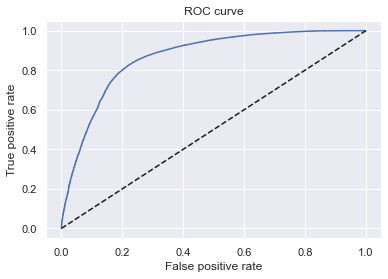

In [ ]:
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle="--", color="k")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve");

In [ ]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba["y_test_class_actual"], y_test_proba["y_hat_test_proba"])
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
# print AUROC and Gini
print("AUROC: %.4f" % (AUROC))
print("Gini: %.4f" % (Gini))

AUROC: 0.8662
Gini: 0.7323


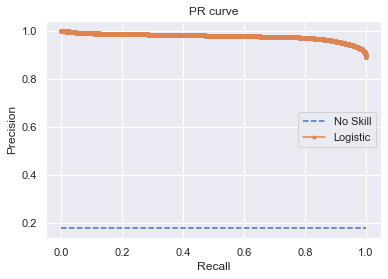

In [ ]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label="No Skill")
# get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(
    y_test_proba["y_test_class_actual"], y_test_proba["y_hat_test_proba"]
)
# plot PR curve
plt.plot(recall, precision, marker=".", label="Logistic")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("PR curve");

In [ ]:
# create a new dataframe with one column with values from the 'reference_categories' list
df_ref_categories = pd.DataFrame(ref_categories, columns=["Feature name"])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories["Coefficients"] = 0

# Concatenates two dataframes
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reset the index
df_scorecard.reset_index(inplace=True)

# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column
df_scorecard["Original feature name"] = df_scorecard["Feature name"].str.split(":").str[0]

# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby("Original feature name")["Coefficients"].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby("Original feature name")["Coefficients"].max().sum()
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard["Score - Calculation"] = (
    df_scorecard["Coefficients"] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
)
# update the calculated score of the Intercept
df_scorecard.loc[0, "Score - Calculation"] = (
    (df_scorecard.loc[0, "Coefficients"] - min_sum_coef) / (max_sum_coef - min_sum_coef)
) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard["Score - Preliminary"] = df_scorecard["Score - Calculation"].round()

# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby("Original feature name")["Score - Preliminary"].min().sum()
max_sum_score_prel = df_scorecard.groupby("Original feature name")["Score - Preliminary"].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard["Difference"] = df_scorecard["Score - Preliminary"] - df_scorecard["Score - Calculation"]

# look like we can get by deducting 1 from the Intercept
df_scorecard["Score - Final"] = df_scorecard["Score - Preliminary"]
df_scorecard.loc[0, "Score - Final"] = 598

# Recheck min and max possible scores
print(df_scorecard.groupby("Original feature name")["Score - Final"].min().sum())
print(df_scorecard.groupby("Original feature name")["Score - Final"].max().sum())

# calculate credit scores for test set
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, "Intercept", 1)

# get the list of our final scorecard scores
scorecard_scores = df_scorecard["Score - Final"]
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard,
# it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat(
    [
        X_test_woe_transformed,
        pd.DataFrame(
            dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), index=X_test_woe_transformed.index
        ),
    ],
    axis=1,
)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)

# Score cutoff for loan approvals
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best Threshold: %f" % (best_thresh))

# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns=["thresholds"])
# calcue Score corresponding to each threshold
df_cutoffs["Score"] = (
    (np.log(df_cutoffs["thresholds"] / (1 - df_cutoffs["thresholds"])) - min_sum_coef)
    * ((max_score - min_score) / (max_sum_coef - min_sum_coef))
    + min_score
).round()

# define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold.
def n_approved(p):
    return np.where(y_test_proba["y_hat_test_proba"] >= p, 1, 0).sum()


# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs["N Approved"] = df_cutoffs["thresholds"].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs["N Rejected"] = y_test_proba["y_hat_test_proba"].shape[0] - df_cutoffs["N Approved"]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs["Approval Rate"] = df_cutoffs["N Approved"] / y_test_proba["y_hat_test_proba"].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs["Rejection Rate"] = 1 - df_cutoffs["Approval Rate"]

# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs["thresholds"].between(0.18657, 0.18658)]

300.0
850.0
300.0
850.0
(93257, 85)
(102,)
(93257, 102)
(102, 1)
Best Threshold: 0.186736


,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
6687,0.186571,488.0,86383,6874,0.92629,0.07371


In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()